In [1]:
from skimage.transform import resize
import os
from multiprocessing import pool
import pickle
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from preprocess import preprocess_image

In [2]:
path = "/Users/Thanh/master/Visualization_lab/SAM/database/training/patient001"
os.chdir(path)

In [3]:
image_001_frame01 = nib.load("patient001_frame01.nii.gz")

(216, 256, 10)
(216, 256, 10)


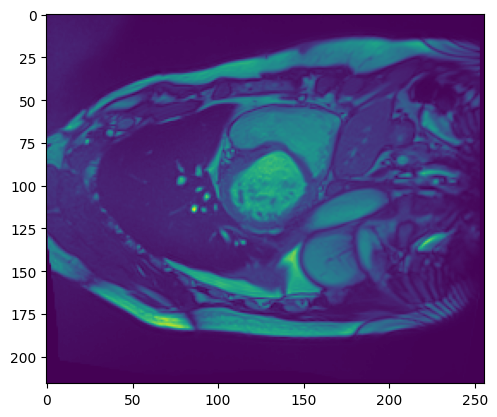

In [16]:
print(image_001_frame01.shape)
image_array = image_001_frame01.get_fdata()
img = resize(image_array, (216,256,10), order=3)
img -= img.mean()
img /= img.std()
print(img.shape)
plt.imshow(img[:,:,1])

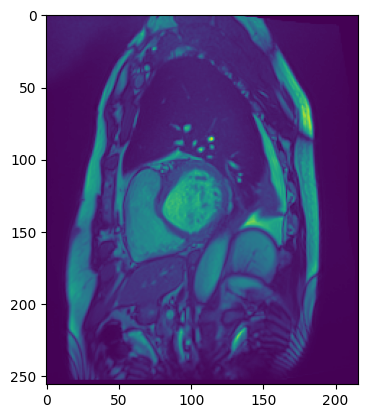

In [18]:
b = img.transpose()
b.shape
plt.imshow(b[1,:,:])

[218, 256, 10]


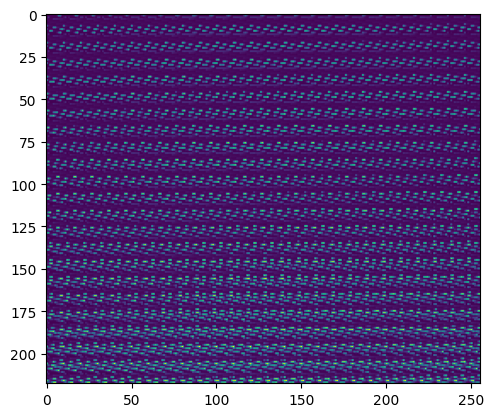

In [6]:
img2 = preprocess_image(image_001_frame01,keep_z_spacing=True)
plt.imshow(img2[1,:,:])

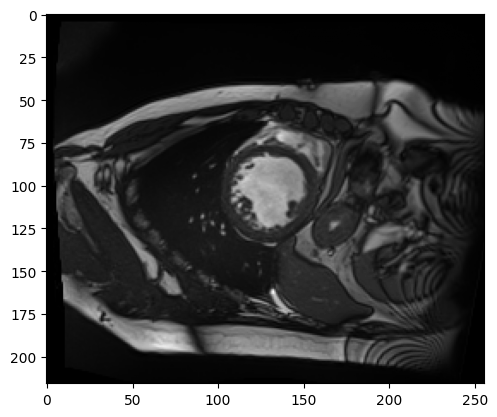

In [15]:
plt.imshow(img[:,:,5],cmap ="gray")

In [7]:
image_001_frame12 = nib.load("patient001_frame01.nii.gz")

In [10]:
np.array(image_001_frame12.header.get_zooms())[[2,1,0]]

array([10.    ,  1.5625,  1.5625], dtype=float32)

In [11]:
image_001_frame12.shape

(216, 256, 10)

In [12]:
image_001 = sitk.ReadImage("patient001_4d.nii.gz")

NameError: name 'sitk' is not defined

In [ ]:
array_image001 = sitk.GetArrayFromImage(image_001)

In [ ]:
array_image001.shape

(30, 10, 256, 216)

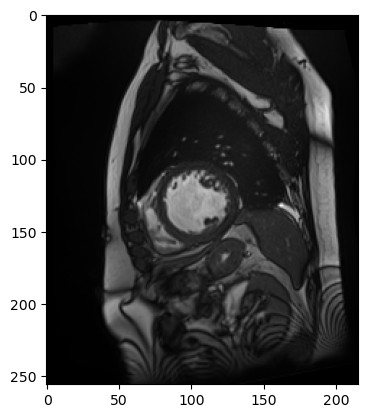

In [ ]:
plt.imshow(array_image001[2,5,:,:],cmap ="gray")

In [ ]:
np.array(image_001.GetSpacing())

array([ 1.5625,  1.5625, 10.    ,  1.    ])

In [ ]:
image_001nib = nib.load("patient001_4d.nii.gz")

In [ ]:
np.array(image_001nib.header.get_zooms())

array([ 1.5625,  1.5625, 10.    ,  1.    ], dtype=float32)

In [28]:
def resize_image(image, old_spacing, new_spacing, order=3):# -> Any:
    new_shape = (int(np.round(old_spacing[0]/new_spacing[0]*float(image.shape[0]))),
                 int(np.round(old_spacing[1]/new_spacing[1]*float(image.shape[1]))),
                 int(np.round(old_spacing[2]/new_spacing[2]*float(image.shape[2]))))
    return resize(image, new_shape, order=order, mode='edge')

def convert_to_one_hot(seg):
    vals = np.unique(seg)
    res = np.zeros([len(vals)] + list(seg.shape), seg.dtype)
    for c in range(len(vals)):
        res[c][seg == c] = 1
    return res


def preprocess_image(nib_image, spacing_target, is_seg=False, keep_z_spacing=False):
    spacing = np.array(nib_image.header.get_zooms())[[2, 1, 0]]
    image = nib_image.get_fdata()
    if keep_z_spacing:
        spacing_target = list(spacing_target)
        spacing_target[0] = spacing[0]
    if not is_seg:
        order_img = 3
        if not keep_z_spacing:
            order_img = 1
        image = resize_image(image, spacing, spacing_target, order=order_img).astype(np.float32)
        image -= image.mean()
        image /= image.std()
    else:
        tmp = convert_to_one_hot(image)
        vals = np.unique(image)
        results = []
        for i in range(len(tmp)):
            results.append(resize_image(tmp[i].astype(float), spacing, spacing_target, 1)[None])
        image = vals[np.vstack(results).argmax(0)]
    return image

str_to_ind = {'DCM':0, 'HCM':1, 'MINF':2, 'NOR':3, 'RV':4}
ind_to_str = {}
for k in str_to_ind.keys():
    ind_to_str[str_to_ind[k]] = k

def process_patient(idx, patient_info, folder, folder_out, keep_z_spc):
    #print id
    # if id in [286, 288]:
    #     return
    patient_folder = os.path.join(folder, "patient%03.0d"%idx)
    if not os.path.isdir(patient_folder):
        return
    images = {}

    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d.nii.gz" % (idx, patient_info[idx]['ED']))
    if os.path.isfile(fname):
        images["ed"] = nib.load(fname)
    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d_gt.nii.gz" % (idx, patient_info[idx]['ED']))
    if os.path.isfile(fname):
        images["ed_seg"] = nib.load(fname)
    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d.nii.gz" % (idx, patient_info[idx]['ES']))
    if os.path.isfile(fname):
        images["es"] = nib.load(fname)
    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d_gt.nii.gz" % (idx, patient_info[idx]['ES']))
    if os.path.isfile(fname):
        images["es_seg"] = nib.load(fname)


    for k in images.keys():
        #print k
        images[k] = preprocess_image(images[k],spacing_target=(10, 1.25, 1.25), is_seg=(k == "ed_seg" or k == "es_seg"),keep_z_spacing=keep_z_spc)

    img_as_list = []
    for k in ['ed', 'ed_seg', 'es', 'es_seg']:
        if k not in images.keys():
            print(f"{idx} has missing key {k}")
        img_as_list.append(images[k][None])
    # Save all images of a patient in a stack of numpy in a folder
    try:
        all_img = np.vstack(img_as_list)
    except:
        print(f"{idx} has a problem with spacings")
    np.save(os.path.join(folder_out, "pat_%03.0d" %idx), all_img.astype(np.float32))
    
def generate_patient_info(folder,idx_start,idx_stop):
    patient_info={}
    for idx in range(idx_start,idx_stop+1):
        fldr = os.path.join(folder, 'patient%03.0d'%idx)
        print(fldr)
        if not os.path.isdir(fldr):
            print (f"could not find dir of patient {idx}")
            continue
        nfo = np.loadtxt(os.path.join(fldr, "Info.cfg"), dtype=str)
        print(patient_info)
        patient_info[idx] = {}
        patient_info[idx]['ed'] = int(nfo[0, 1])
        patient_info[idx]['es'] = int(nfo[1, 1])
        patient_info[idx]['height'] = float(nfo[3, 1])
        patient_info[idx]['pathology'] = nfo[2, 1]
        patient_info[idx]['weight'] = float(nfo[5, 1])
    return patient_info

# Did not test this yet
# To run the data preprocessing simultaneouly for big dataset
def run_preprocessing(folder_in,folder_out, idx_start,idx_stop, keep_z_spacing=True):
    patient_info = generate_patient_info(folder_in)

    if not os.path.isdir(folder_out):
        os.mkdir(folder_out)
    with open(os.path.join(folder_out, "patient_info.pkl"), 'w') as f:
        pickle.dump(patient_info, f)

    # beware of z spacing!!! see process_patient for more info!
    ids = range(idx_start,idx_stop+1)
    p = pool.Pool(8)
    p.map(process_patient, zip(ids, [patient_info]*len(ids), [folder]*len(ids), [folder_out]*len(ids), [keep_z_spacing]*len(ids)))
    p.close()
    p.join()


In [180]:
os.chdir("/Users/Thanh/master/Visualization_lab/SAM/database/training/patient001")
patient_001 = nib.load("patient001_frame01.nii.gz")
after = preprocess_image(patient_001,spacing_target=(10, 1.25, 1.25),keep_z_spacing=True)

In [52]:
after.shape

(216, 320, 12)

In [47]:
patient_001.shape

(216, 256, 10)

[[-0.62417024 -0.59255487 -0.5774781  ... -0.89467126 -0.89438874
  -0.89467126]
 [-0.6256632  -0.56635296 -0.4970462  ... -0.8924083  -0.89078885
  -0.8911882 ]
 [-0.5936517  -0.5614121  -0.5170472  ... -0.89250803 -0.89076126
  -0.89119196]
 ...
 [-0.89467126 -0.89467126 -0.8946712  ... -0.8946698  -0.89467126
  -0.8946712 ]
 [-0.89467126 -0.89467126 -0.8946712  ... -0.89466995 -0.89467126
  -0.8946712 ]
 [-0.89467126 -0.89467126 -0.89467126 ... -0.89467126 -0.89467126
  -0.89467126]]


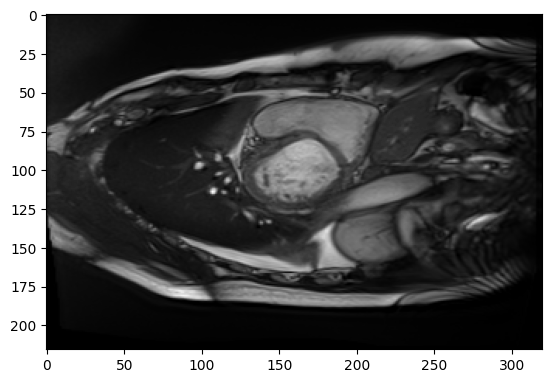

In [179]:
plt.imshow(after[:,:,1],cmap ="gray")

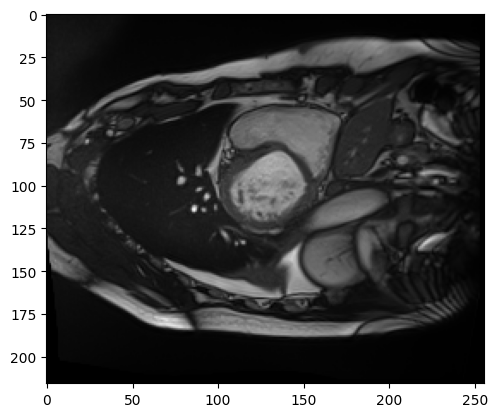

In [33]:
plt.imshow(patient_001.get_fdata()[:,:,1],cmap ="gray")

In [196]:
patient_001_gt = nib.load("patient001_frame01_gt.nii.gz")
after_gt = preprocess_image(patient_001_gt,is_seg = True, spacing_target=(10, 1.25, 1.25),keep_z_spacing=True)

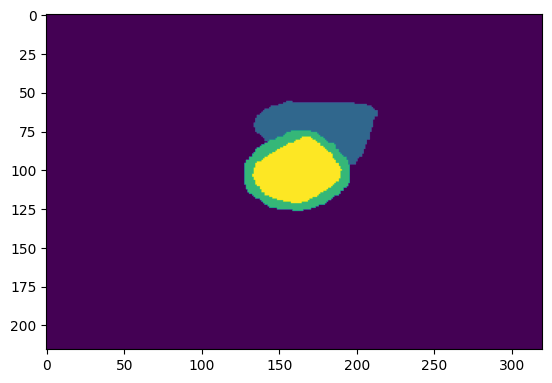

In [200]:
plt.imshow(after_gt[:,:,1])

In [ ]:
patient_info = generate_patient_info("/Users/Thanh/master/Visualization_lab/SAM/database/training",1,5)

/Users/Thanh/master/Visualization_lab/SAM/database/training/patient001
{}
/Users/Thanh/master/Visualization_lab/SAM/database/training/patient002
{1: {'ed': 1, 'es': 12, 'height': 184.0, 'pathology': 'DCM', 'weight': 95.0}}
/Users/Thanh/master/Visualization_lab/SAM/database/training/patient003
{1: {'ed': 1, 'es': 12, 'height': 184.0, 'pathology': 'DCM', 'weight': 95.0}, 2: {'ed': 1, 'es': 12, 'height': 160.0, 'pathology': 'DCM', 'weight': 70.0}}
/Users/Thanh/master/Visualization_lab/SAM/database/training/patient004
{1: {'ed': 1, 'es': 12, 'height': 184.0, 'pathology': 'DCM', 'weight': 95.0}, 2: {'ed': 1, 'es': 12, 'height': 160.0, 'pathology': 'DCM', 'weight': 70.0}, 3: {'ed': 1, 'es': 15, 'height': 165.0, 'pathology': 'DCM', 'weight': 77.0}}
/Users/Thanh/master/Visualization_lab/SAM/database/training/patient005
{1: {'ed': 1, 'es': 12, 'height': 184.0, 'pathology': 'DCM', 'weight': 95.0}, 2: {'ed': 1, 'es': 12, 'height': 160.0, 'pathology': 'DCM', 'weight': 70.0}, 3: {'ed': 1, 'es': 15,

In [ ]:
os.chdir("/Users/Thanh/master/Visualization_lab/SAM/database/training/patient001")

In [ ]:
nfo = np.loadtxt("Info.cfg", dtype=str)

In [ ]:
nfo[0,1]

'1'

In [ ]:
patient_info

{1: {'ed': 1, 'es': 12, 'height': 184.0, 'pathology': 'DCM', 'weight': 95.0},
 2: {'ed': 1, 'es': 12, 'height': 160.0, 'pathology': 'DCM', 'weight': 70.0},
 3: {'ed': 1, 'es': 15, 'height': 165.0, 'pathology': 'DCM', 'weight': 77.0},
 4: {'ed': 1, 'es': 15, 'height': 159.0, 'pathology': 'DCM', 'weight': 46.0},
 5: {'ed': 1, 'es': 13, 'height': 165.0, 'pathology': 'DCM', 'weight': 77.0}}

# **Test SAM**

In [83]:
import os
import cv2
#Load the model
import torch
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
#from skimage.transform import resize
os.chdir("/Users/Thanh/sam-lab")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [39]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

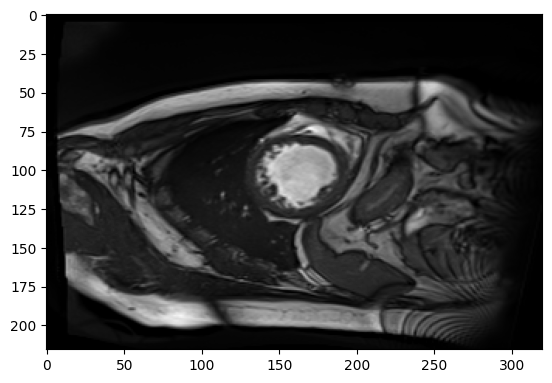

In [182]:
# Use slice 7 in the image for checking SAM
gray = after[:,:,7]
plt.imshow(gray, cmap = "gray")


[42 42 42 ... 43 43 43]


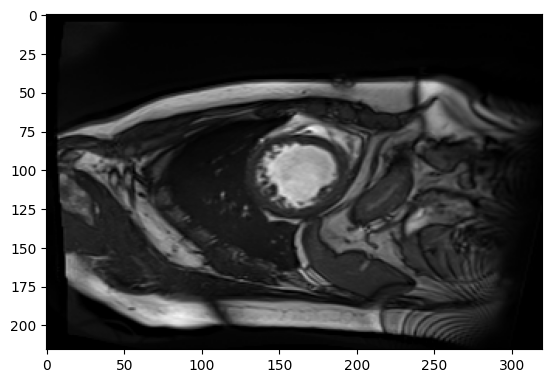

In [189]:

# Convert to RGB
img = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
# Change pixel values from [-1,1] to [0,255] range, np.uint8 type because SAM only accepts these values for RGB image
img2 = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
img2 = img2.astype(np.uint8)
print(img2[img2>0])
plt.imshow(img2)

In [190]:
predictor = SamPredictor(sam)
predictor.set_image(img2)
image_embedding = predictor.get_image_embedding()
image_embedding.shape

torch.Size([1, 256, 64, 64])

In [204]:
image_embedding

tensor([[[[ 0.1055,  0.0329, -0.1010,  ..., -0.0477, -0.0420, -0.0127],
          [ 0.1822,  0.1251, -0.1134,  ..., -0.0275, -0.0229,  0.0181],
          [ 0.1892,  0.1098, -0.2235,  ..., -0.0519, -0.0654, -0.0284],
          ...,
          [-0.0599, -0.0781, -0.0810,  ..., -0.1313, -0.1289, -0.1372],
          [-0.0682, -0.0826, -0.0840,  ..., -0.1271, -0.1259, -0.1338],
          [-0.0911, -0.0908, -0.0926,  ..., -0.1115, -0.1073, -0.1013]],

         [[ 0.0217,  0.0224,  0.0009,  ..., -0.0714, -0.0626, -0.0456],
          [ 0.0801,  0.0446, -0.0984,  ..., -0.1644, -0.1606, -0.0781],
          [ 0.0439,  0.0029, -0.0952,  ..., -0.1458, -0.1182, -0.0527],
          ...,
          [ 0.0448,  0.0510,  0.0491,  ...,  0.1096,  0.1116,  0.0911],
          [ 0.0530,  0.0578,  0.0576,  ...,  0.1122,  0.1146,  0.0935],
          [ 0.0378,  0.0697,  0.0711,  ...,  0.1159,  0.1146,  0.0979]],

         [[-0.0278, -0.0670, -0.1191,  ..., -0.0236, -0.0243, -0.0367],
          [-0.1019, -0.0907, -

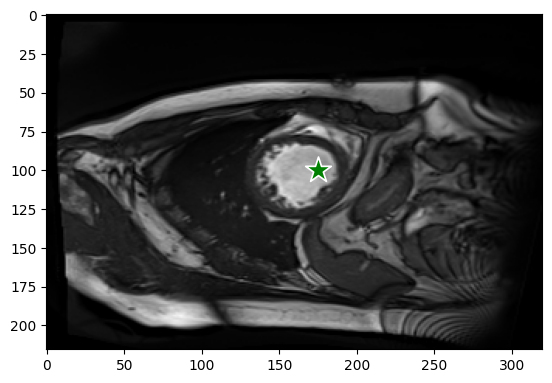

In [192]:
input_point = np.array([[175, 100]]) #coordinates of the input point
input_label = np.array([1]) # type of input point (1: forground; 0: background)
plt.imshow(img2)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() 

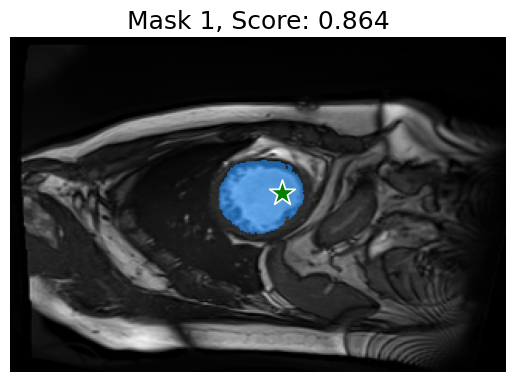

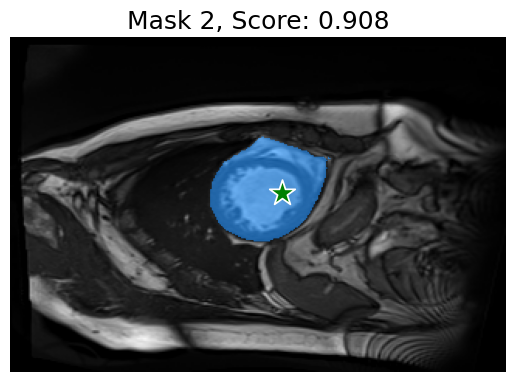

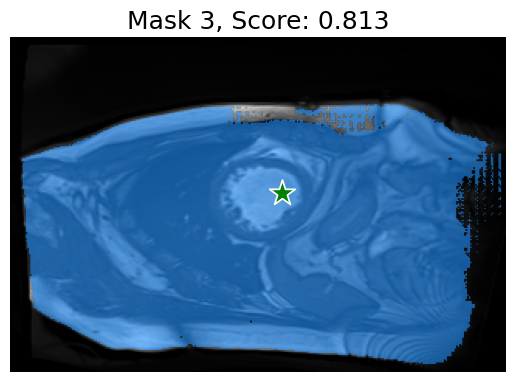

In [205]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure()
    plt.imshow(img2)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

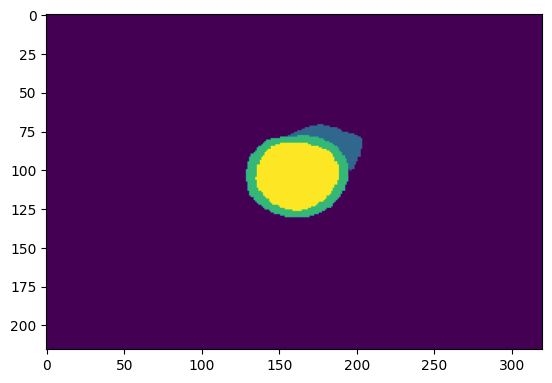

In [198]:
plt.imshow(after_gt[:,:,7])